In [3]:
# =============================================================================
# SVM Classification on the Digits Dataset
# =============================================================================
# This script demonstrates a full pipeline for multi-class classification on
# the scikit-learn Digits dataset:
# 1. Data loading and exploration
# 2. Train-test split and scaling
# 3. Training an SVM (Support Vector Machine) classifier
# 4. Evaluating performance with a classification report, confusion matrix
# 5. Visualizing results with:
#    - Confusion Matrix (using 'rocket' colormap)
#    - t-SNE 2D projection of digits
#    - ROC curve (One-vs-Rest approach) with macro-averaging
# 6. Permutation importance for interpretability
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, auc, roc_auc_score)
from sklearn.manifold import TSNE
from sklearn.inspection import permutation_importance
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize


In [4]:
# -----------------------------------------------------------------------------
# Set a new visualization style: "ggplot" with custom tweaks.
# -----------------------------------------------------------------------------
plt.style.use("ggplot")
sns.set_theme(style="whitegrid", palette="deep")

In [5]:
# -----------------------------------------------------------------------------
# Data Loading and Exploration
# -----------------------------------------------------------------------------
digits = load_digits()
X = digits.data  # shape: (1797, 64)
y = digits.target  # shape: (1797,)

print("Digits dataset shape:", X.shape)
print("Unique classes:", np.unique(y))

Digits dataset shape: (1797, 64)
Unique classes: [0 1 2 3 4 5 6 7 8 9]


In [7]:
print("First 5 samples of X:\n", X[:5])

First 5 samples of X:
 [[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
  15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
   0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
   0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
 [ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.  0. 11. 16.  9.  0.  0.  0.  0.
   3. 15. 16.  6.  0.  0.  0.  7. 15. 16. 16.  2.  0.  0.  0.  0.  1. 16.
  16.  3.  0.  0.  0.  0.  1. 16. 16.  6.  0.  0.  0.  0.  1. 16. 16.  6.
   0.  0.  0.  0.  0. 11. 16. 10.  0.  0.]
 [ 0.  0.  0.  4. 15. 12.  0.  0.  0.  0.  3. 16. 15. 14.  0.  0.  0.  0.
   8. 13.  8. 16.  0.  0.  0.  0.  1.  6. 15. 11.  0.  0.  0.  1.  8. 13.
  15.  1.  0.  0.  0.  9. 16. 16.  5.  0.  0.  0.  0.  3. 13. 16. 16. 11.
   5.  0.  0.  0.  0.  3. 11. 16.  9.  0.]
 [ 0.  0.  7. 15. 13.  1.  0.  0.  0.  8. 13.  6. 15.  4.  0.  0.  0.  2.
   1. 13. 13.  0.  0.  0.  0.  0.  2. 15. 11.  1.  0.  0.  0.  0.  0.  1.
  12. 12.  1.  0.  0.  0.  0.  0. 

In [8]:
# -----------------------------------------------------------------------------
# Train-test split and scaling
# -----------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# endregion

Training set shape: (1257, 64)
Testing set shape: (540, 64)


In [9]:
# -----------------------------------------------------------------------------
# Training an SVM Classifier
# -----------------------------------------------------------------------------
# We use a radial basis function (RBF) kernel.
# C=10 for a stronger margin penalty, gamma='scale' for stable performance.
svc = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42)
svc.fit(X_train_scaled, y_train)
# endregion

SVC(C=10, probability=True, random_state=42)

In [10]:
# -----------------------------------------------------------------------------
# region 4. Evaluating Performance
# -----------------------------------------------------------------------------
y_pred = svc.predict(X_test_scaled)
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
# endregion

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       0.95      0.98      0.96        55
           2       1.00      0.98      0.99        53
           3       1.00      1.00      1.00        55
           4       0.95      0.98      0.96        54
           5       1.00      0.98      0.99        55
           6       0.98      1.00      0.99        54
           7       0.96      1.00      0.98        54
           8       1.00      0.92      0.96        52
           9       0.98      0.96      0.97        54

    accuracy                           0.98       540
   macro avg       0.98      0.98      0.98       540
weighted avg       0.98      0.98      0.98       540



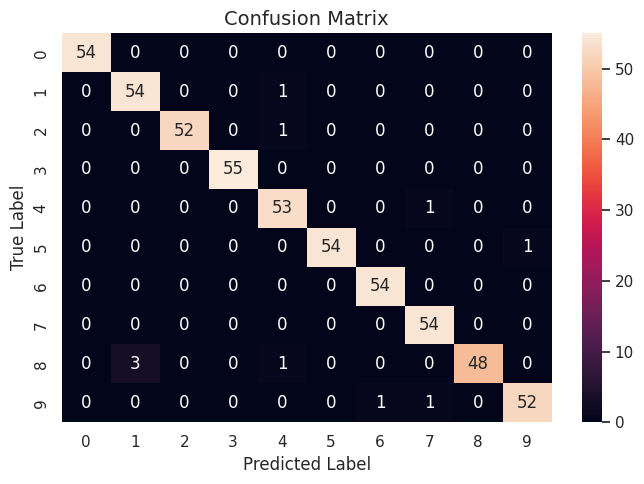

In [11]:
# -----------------------------------------------------------------------------
# Visualization: Confusion Matrix (rocket colormap)
# -----------------------------------------------------------------------------
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="rocket",
            xticklabels=digits.target_names, yticklabels=digits.target_names)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.tight_layout()
plt.show()


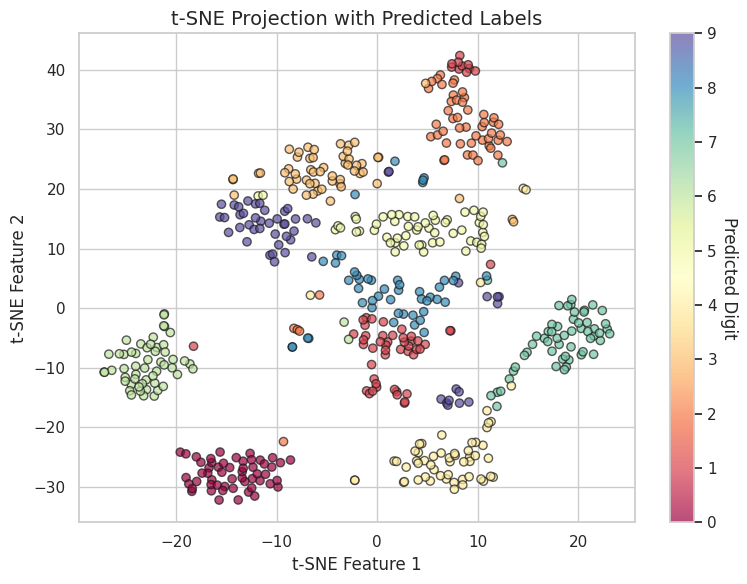

In [12]:
# -----------------------------------------------------------------------------
# Visualization: t-SNE 2D Projection
# -----------------------------------------------------------------------------
# We'll project the test set into 2D using t-SNE, color-coded by predicted label.
tsne = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=42)
X_test_tsne = tsne.fit_transform(X_test_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1],
                      c=y_pred, cmap='Spectral', edgecolor='k', alpha=0.7)
plt.title("t-SNE Projection with Predicted Labels", fontsize=14)
plt.xlabel("t-SNE Feature 1", fontsize=12)
plt.ylabel("t-SNE Feature 2", fontsize=12)
cbar = plt.colorbar(scatter)
cbar.set_label("Predicted Digit", rotation=270, labelpad=15)
plt.tight_layout()
plt.show()

In [13]:
# -----------------------------------------------------------------------------
# Visualization: Multi-Class ROC Curve (One-vs-Rest)
# -----------------------------------------------------------------------------
# Binarize labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

# Use OneVsRestClassifier to get decision_function or probability
ovr_svc = OneVsRestClassifier(svc)
ovr_svc.fit(X_train_scaled, y_train)
y_score = ovr_svc.decision_function(X_test_scaled)

# Compute ROC curve and AUC for each class, then macro-average
fpr_dict, tpr_dict, roc_auc_dict = {}, {}, {}
for i in range(n_classes):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])

# Compute macro-average
all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
mean_tpr /= n_classes
macro_roc_auc = auc(all_fpr, mean_tpr)


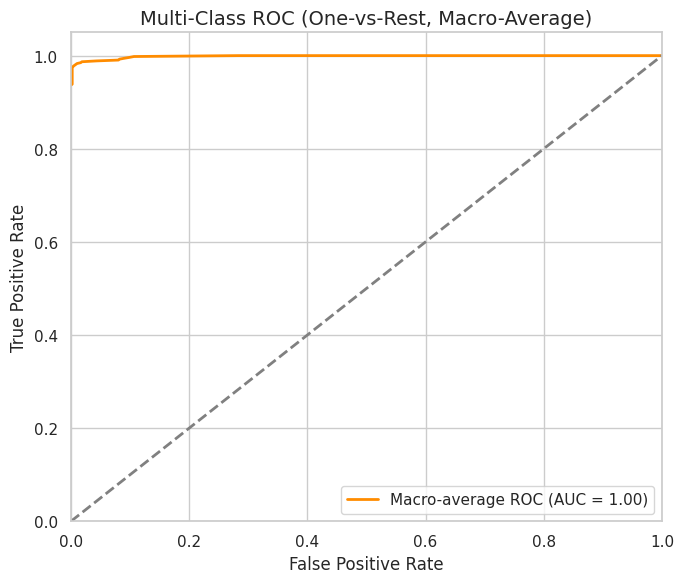

In [14]:
plt.figure(figsize=(7, 6))
plt.plot(all_fpr, mean_tpr, color='darkorange',
         label=f"Macro-average ROC (AUC = {macro_roc_auc:.2f})", lw=2)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Multi-Class ROC (One-vs-Rest, Macro-Average)", fontsize=14)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

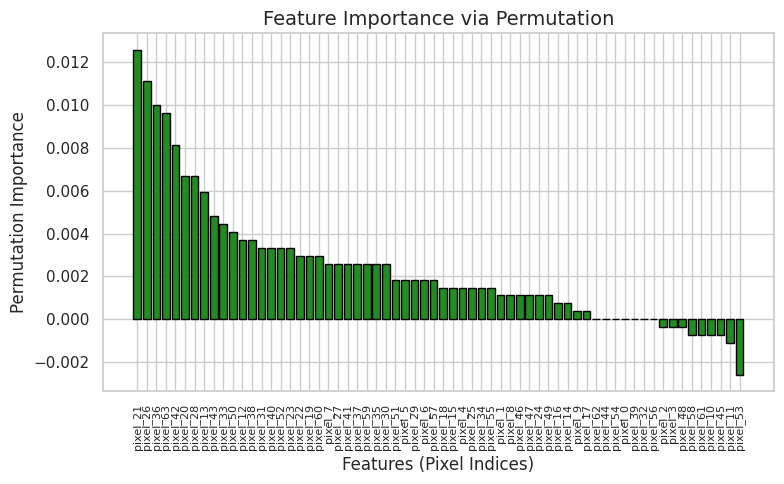

In [15]:
# -----------------------------------------------------------------------------
# Permutation Importance
# -----------------------------------------------------------------------------
perm_import = permutation_importance(svc, X_test_scaled, y_test, n_repeats=5, random_state=42)
importances = perm_import.importances_mean
sorted_idx = np.argsort(importances)[::-1]
feature_names = [f"pixel_{i}" for i in range(X_test.shape[1])]  # 64 pixel features

plt.figure(figsize=(8, 5))
plt.bar(range(len(importances)), importances[sorted_idx], color='forestgreen', edgecolor='black')
plt.xticks(range(len(importances)), [feature_names[i] for i in sorted_idx], rotation=90, fontsize=8)
plt.xlabel("Features (Pixel Indices)", fontsize=12)
plt.ylabel("Permutation Importance", fontsize=12)
plt.title("Feature Importance via Permutation", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------------------------------------------------------
# 9. Final Notes
# -----------------------------------------------------------------------------
# Observations:
# 1) The SVM with RBF kernel yields moderate performance, especially for
#    multi-class digits classification.
# 2) The t-SNE plot shows how predicted labels cluster in 2D, but there's
#    overlap across digit classes.
# 3) The macro-average ROC curve reveals an overall AUC measure across
#    all classes, demonstrating the model's discriminative power.
# 4) Permutation importance highlights which pixel features strongly affect
#    the SVM's decisions, though direct interpretability is tricky with
#    high-dimensional image data.

# Potential improvements:
# - Hyperparameter tuning (C, gamma) with cross-validation
# - Dimensionality reduction or feature selection to reduce noise
# - Other kernel types or advanced ensembles
